# Summary Figures: Conservation, Fitness, and Genome Architecture

Cross-project figures combining results from conservation_vs_fitness,
fitness_effects_conservation, module_conservation, and core_gene_tradeoffs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from pathlib import Path

# Upstream project data
CONS_DIR = Path('../../conservation_vs_fitness/data')
FE_DIR = Path('../../fitness_effects_conservation/data')
MOD_DIR = Path('../../fitness_modules/data/modules')
FIGURES_DIR = Path('../figures')
FIGURES_DIR.mkdir(exist_ok=True)

# Load core datasets
fs = pd.read_csv(FE_DIR / 'fitness_stats.tsv', sep='\t')
link = pd.read_csv(CONS_DIR / 'fb_pangenome_link.tsv', sep='\t')
link = link[link['orgId'] != 'Dyella79']
essential = pd.read_csv(CONS_DIR / 'essential_genes.tsv', sep='\t', low_memory=False)
essential = essential[(essential['orgId'] != 'Dyella79') & (essential['is_essential'])]
seed = pd.read_csv(CONS_DIR / 'seed_annotations.tsv', sep='\t')
hier = pd.read_csv(CONS_DIR / 'seed_hierarchy.tsv', sep='\t').drop_duplicates('seed_desc', keep='first')

# Build unified dataset (fitness genes + essential genes)
ess_rows = essential[['orgId', 'locusId']].copy()
for col in ['n_experiments','min_fit','max_fit','mean_fit','n_sick','n_very_sick',
            'n_beneficial','n_very_beneficial','n_significant']:
    ess_rows[col] = np.nan if 'fit' in col else 0
ess_rows['is_essential'] = True
fs['is_essential'] = False
all_genes = pd.concat([fs, ess_rows], ignore_index=True)

# Merge with conservation
merged = all_genes.merge(
    link[['orgId','locusId','is_core','is_singleton','is_auxiliary','gene_cluster_id']],
    on=['orgId','locusId'], how='left'
)
merged['is_mapped'] = merged['gene_cluster_id'].notna()
merged['conservation'] = 'unmapped'
merged.loc[merged['is_mapped'] & (merged['is_core'] == True), 'conservation'] = 'core'
merged.loc[merged['is_mapped'] & (merged['is_singleton'] == True), 'conservation'] = 'singleton'
merged.loc[merged['is_mapped'] & (merged['is_core'] != True) & (merged['is_singleton'] != True), 'conservation'] = 'auxiliary'

# Fitness profiles
merged['profile'] = 'always_neutral'
merged.loc[merged['n_beneficial'] > 0, 'profile'] = 'sometimes_beneficial'
merged.loc[merged['n_sick'] > 0, 'profile'] = 'sometimes_sick'
merged.loc[(merged['n_beneficial'] > 0) & (merged['n_sick'] > 0), 'profile'] = 'mixed'
merged.loc[(merged['n_sick'] / merged['n_experiments'].replace(0, np.nan)) > 0.1, 'profile'] = 'often_sick'
merged.loc[merged['is_essential'], 'profile'] = 'essential'

# Add annotations
merged = merged.merge(seed, on=['orgId','locusId'], how='left')
merged = merged.merge(hier[['seed_desc','toplevel']], on='seed_desc', how='left')
merged['is_burden'] = merged['n_beneficial'] > 0
merged['is_tradeoff'] = (merged['n_sick'] > 0) & (merged['n_beneficial'] > 0)

print(f'Total genes: {len(merged):,} ({merged["is_essential"].sum():,} essential)')
print(f'Mapped: {merged["is_mapped"].sum():,}')

Total genes: 194,216 (27,693 essential)
Mapped: 168,624


## Figure 1: The Fitness-Conservation Gradient

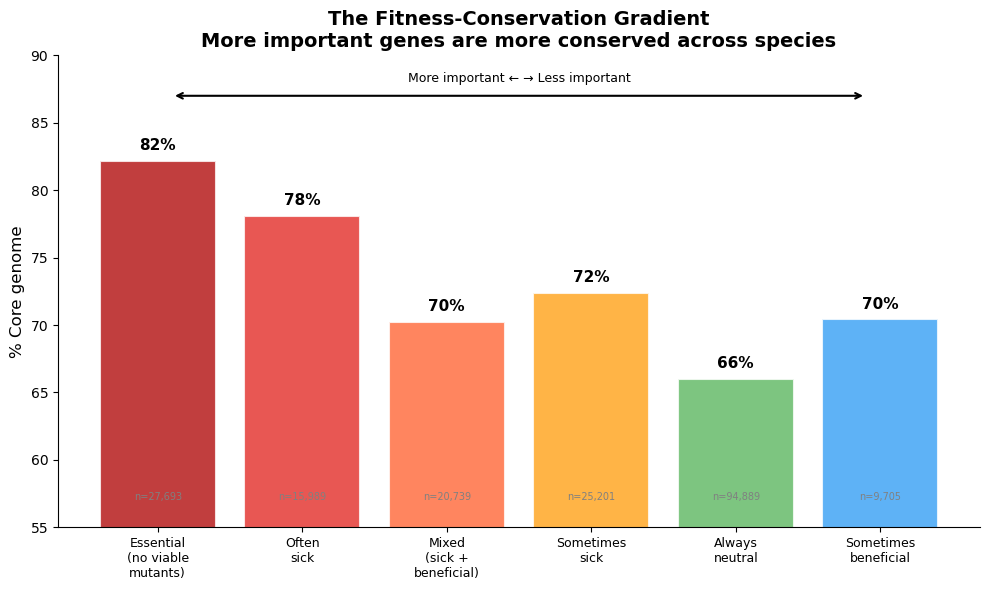

Note: % core computed over ALL genes including unmapped (unmapped = unknown conservation).
This matches the upstream fitness_effects_conservation project numbers.


In [2]:
profile_order = ['essential', 'often_sick', 'mixed', 'sometimes_sick',
                 'always_neutral', 'sometimes_beneficial']
profile_labels = ['Essential\n(no viable\nmutants)', 'Often\nsick', 'Mixed\n(sick +\nbeneficial)',
                  'Sometimes\nsick', 'Always\nneutral', 'Sometimes\nbeneficial']

# Use ALL genes as denominator (including unmapped) — matches upstream project numbers
# Unmapped genes are treated as "not core" (unknown conservation)
pct_core = []
counts = []
for prof in profile_order:
    d = merged[merged['profile'] == prof]
    pct_core.append((d['is_core'] == True).sum() / len(d) * 100 if len(d) > 0 else 0)
    counts.append(len(d))

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#B71C1C', '#E53935', '#FF7043', '#FFA726', '#66BB6A', '#42A5F5']
bars = ax.bar(range(len(profile_order)), pct_core, color=colors, alpha=0.85,
              edgecolor='white', linewidth=1.5)

ax.set_xticks(range(len(profile_order)))
ax.set_xticklabels(profile_labels, fontsize=9)
ax.set_ylabel('% Core genome', fontsize=12)
ax.set_title('The Fitness-Conservation Gradient\n'
             'More important genes are more conserved across species',
             fontsize=14, fontweight='bold')
ax.set_ylim(55, 90)

# Add values and counts
for i, (pct, n) in enumerate(zip(pct_core, counts)):
    ax.text(i, pct + 0.8, f'{pct:.0f}%', ha='center', fontsize=11, fontweight='bold')
    ax.text(i, 57, f'n={n:,}', ha='center', fontsize=7, color='gray')

# Arrow showing gradient direction
ax.annotate('', xy=(0.1, 87), xytext=(4.9, 87),
            arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
ax.text(2.5, 88, 'More important \u2190 \u2192 Less important', ha='center', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fitness_conservation_gradient.png', dpi=200, bbox_inches='tight')
plt.show()

print(f'Note: % core computed over ALL genes including unmapped (unmapped = unknown conservation).')
print(f'This matches the upstream fitness_effects_conservation project numbers.')

## Figure 2: The Selection Signature

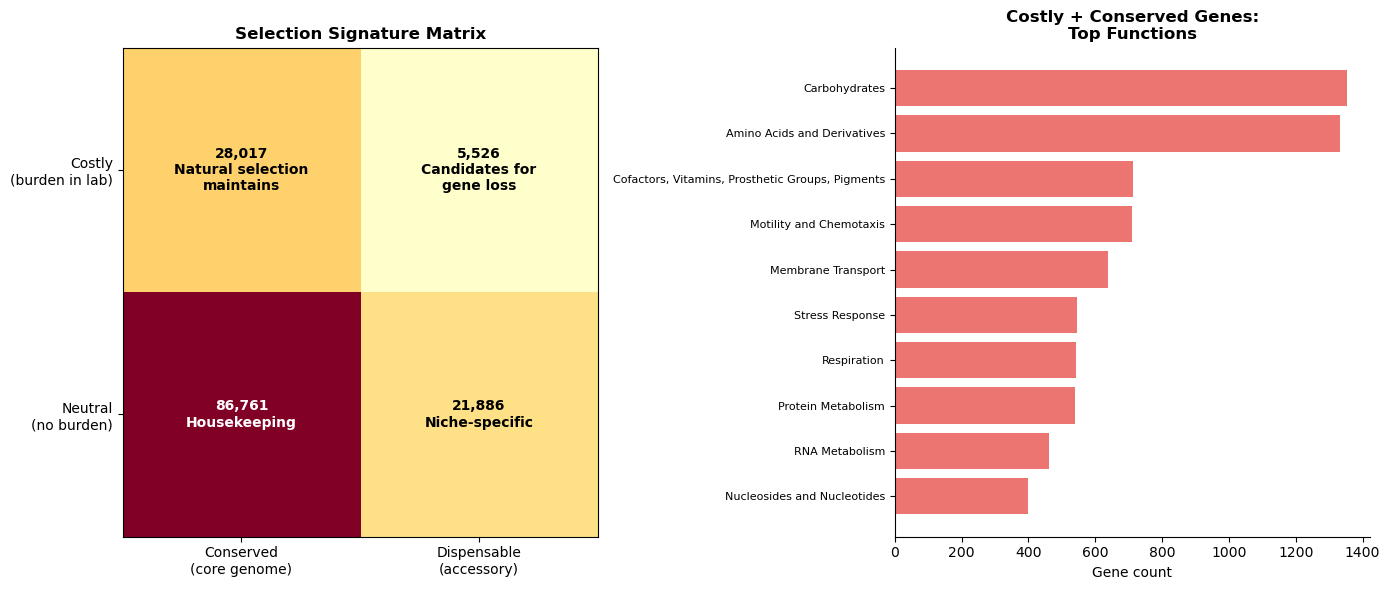

In [3]:
# Only non-essential mapped genes (burden requires fitness data)
mapped = merged[merged['is_mapped']]
mapped_ne = mapped[~mapped['is_essential']].copy()

# Quadrants
mapped_ne['quadrant'] = 'neutral + dispensable'
mapped_ne.loc[mapped_ne['is_burden'] & (mapped_ne['is_core'] == True), 'quadrant'] = 'costly + conserved'
mapped_ne.loc[mapped_ne['is_burden'] & (mapped_ne['is_core'] != True), 'quadrant'] = 'costly + dispensable'
mapped_ne.loc[~mapped_ne['is_burden'] & (mapped_ne['is_core'] == True), 'quadrant'] = 'neutral + conserved'

quad_counts = mapped_ne['quadrant'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: 2x2 matrix
matrix = np.array([
    [quad_counts.get('costly + conserved', 0), quad_counts.get('costly + dispensable', 0)],
    [quad_counts.get('neutral + conserved', 0), quad_counts.get('neutral + dispensable', 0)]
])

im = axes[0].imshow(matrix, cmap='YlOrRd', aspect='auto')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Conserved\n(core genome)', 'Dispensable\n(accessory)'], fontsize=10)
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['Costly\n(burden in lab)', 'Neutral\n(no burden)'], fontsize=10)
axes[0].set_title('Selection Signature Matrix', fontsize=12, fontweight='bold')

labels = [
    ['Natural selection\nmaintains', 'Candidates for\ngene loss'],
    ['Housekeeping', 'Niche-specific']
]
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, f'{matrix[i,j]:,}\n{labels[i][j]}',
                     ha='center', va='center', fontsize=10,
                     color='white' if matrix[i,j] > 40000 else 'black',
                     fontweight='bold')

# Panel B: Top functions in costly+conserved
cc = mapped_ne[mapped_ne['quadrant'] == 'costly + conserved']
cc_annotated = cc[cc['toplevel'].notna()]
top_funcs = cc_annotated['toplevel'].value_counts().head(10)

axes[1].barh(range(len(top_funcs)), top_funcs.values, color='#E53935', alpha=0.7)
axes[1].set_yticks(range(len(top_funcs)))
axes[1].set_yticklabels(top_funcs.index, fontsize=8)
axes[1].set_xlabel('Gene count')
axes[1].set_title('Costly + Conserved Genes:\nTop Functions', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'selection_signature.png', dpi=200, bbox_inches='tight')
plt.show()

## Figure 3: The Core Genome Is Active

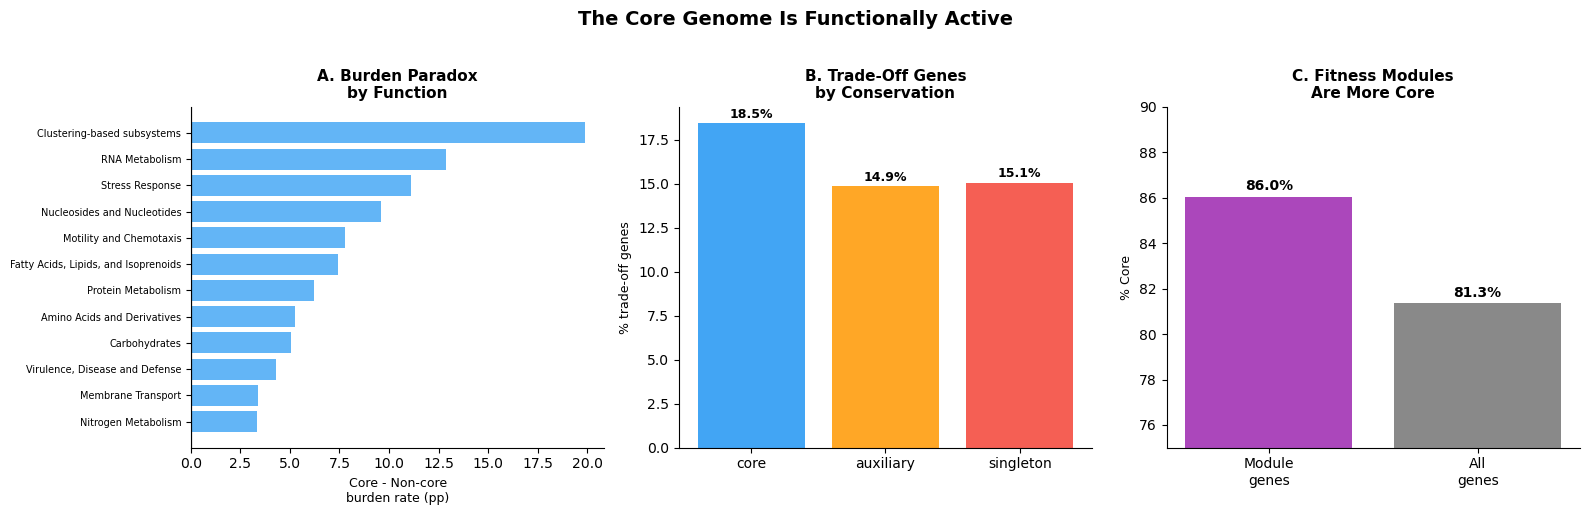

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel A: Core vs non-core burden rate by top SEED categories
mapped_ne = merged[~merged['is_essential'] & merged['is_mapped']].copy()
ann = mapped_ne[mapped_ne['toplevel'].notna()]
burden_core = ann[ann['is_core'] == True].groupby('toplevel')['is_burden'].mean() * 100
burden_noncore = ann[ann['is_core'] != True].groupby('toplevel')['is_burden'].mean() * 100
diff = (burden_core - burden_noncore).dropna().sort_values(ascending=True)

core_n = ann[ann['is_core'] == True].groupby('toplevel').size()
noncore_n = ann[ann['is_core'] != True].groupby('toplevel').size()
good = (core_n >= 50) & (noncore_n >= 50)
diff = diff[diff.index.isin(good[good].index)].tail(12)

colors_a = ['#2196F3' if v > 0 else '#FF9800' for v in diff.values]
axes[0].barh(range(len(diff)), diff.values, color=colors_a, alpha=0.7)
axes[0].axvline(x=0, color='black', linewidth=0.8)
axes[0].set_yticks(range(len(diff)))
axes[0].set_yticklabels(diff.index, fontsize=7)
axes[0].set_xlabel('Core - Non-core\nburden rate (pp)', fontsize=9)
axes[0].set_title('A. Burden Paradox\nby Function', fontsize=11, fontweight='bold')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Panel B: Trade-off enrichment
cats = ['core', 'auxiliary', 'singleton']
tradeoff_rates = [(mapped_ne[mapped_ne['conservation'] == c]['is_tradeoff'].mean() * 100) for c in cats]
bar_colors = ['#2196F3', '#FF9800', '#F44336']
axes[1].bar(range(len(cats)), tradeoff_rates, color=bar_colors, alpha=0.85)
axes[1].set_xticks(range(len(cats)))
axes[1].set_xticklabels(cats, fontsize=10)
axes[1].set_ylabel('% trade-off genes', fontsize=9)
axes[1].set_title('B. Trade-Off Genes\nby Conservation', fontsize=11, fontweight='bold')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
for i, v in enumerate(tradeoff_rates):
    axes[1].text(i, v + 0.3, f'{v:.1f}%', ha='center', fontsize=9, fontweight='bold')

# Panel C: Module genes vs all genes — use merge instead of apply
import os
MOD_DIR = Path('../../fitness_modules/data/modules')
mod_orgs = set(f.replace('_gene_membership.csv','') for f in os.listdir(MOD_DIR)
               if f.endswith('_gene_membership.csv'))
link_orgs = set(link['orgId'].unique())
overlap = sorted(mod_orgs & link_orgs)

module_keys = []
for orgId in overlap:
    mem = pd.read_csv(MOD_DIR / f'{orgId}_gene_membership.csv')
    mcols = [c for c in mem.columns if c.startswith('M')]
    in_mod = mem[mem[mcols].sum(axis=1) > 0]
    for lid in in_mod['locusId']:
        module_keys.append({'orgId': orgId, 'locusId': str(lid)})

module_keys_df = pd.DataFrame(module_keys).drop_duplicates()

link_sub = link[link['orgId'].isin(overlap)].copy()
link_sub['locusId'] = link_sub['locusId'].astype(str)
link_sub = link_sub.merge(module_keys_df, on=['orgId','locusId'], how='left', indicator=True)
link_sub['in_module'] = link_sub['_merge'] == 'both'

mod_core = (link_sub[link_sub['in_module']]['is_core'] == True).mean() * 100
all_core = (link_sub['is_core'] == True).mean() * 100

axes[2].bar([0, 1], [mod_core, all_core], color=['#9C27B0', '#757575'], alpha=0.85)
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Module\ngenes', 'All\ngenes'], fontsize=10)
axes[2].set_ylabel('% Core', fontsize=9)
axes[2].set_title('C. Fitness Modules\nAre More Core', fontsize=11, fontweight='bold')
axes[2].set_ylim(75, 90)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
for i, v in enumerate([mod_core, all_core]):
    axes[2].text(i, v + 0.3, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.suptitle('The Core Genome Is Functionally Active', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'core_genome_active.png', dpi=200, bbox_inches='tight')
plt.show()